# Predicción Click-Through con Random Forest

In [1]:
import csv

def read_ad_click_data(filename, n, offset=0):
    """ Read training instances from the Click-Through Rate Prediction dataset
       (https://www.kaggle.com/c/avazu-ctr-prediction)
    Args:
        filename - Name of file to read instances from
        n - Number of instances to read
        offset - Instance number to begin reading from
    Returns:
        X_dict, y - Features of the read instances (as a dictionary) and corresponding labels (as a list)
        
    Note:
        We exclude features 'id', 'hour', 'device_id', and 'device_ip' from the dataset in order to avoid
        a huge number of features coming from the OHE of these categorical attributes
    """
    X_dict, y = [], []
    
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        
        for i in range(offset):
            next(reader)
            
        i = 0
        for row in reader:
            i += 1
            y.append(int(row['click']))
            del row['click'], row['id'], row['hour'], row['device_id'], row['device_ip']
            X_dict.append(dict(row))
            
            if i >= n:
                break
                
    return X_dict, y

### Cargamos los CSV y hacemos la division de datos en test y train

In [2]:
n_max = 100000 # can be up to 100,000 instances (but requieres A LOT of memory to process)
X_dict_train, y_train = read_ad_click_data('train_ctr.csv', n_max)
X_dict_test, y_test = read_ad_click_data('test_ctr.csv', n_max)

print(X_dict_train[0])
print(X_dict_train[1])
print()
print(X_dict_test[0])
print(X_dict_test[1])

{'C1': '1005', 'banner_pos': '0', 'site_id': '1fbe01fe', 'site_domain': 'f3845767', 'site_category': '28905ebd', 'app_id': 'ecad2386', 'app_domain': '7801e8d9', 'app_category': '07d7df22', 'device_model': '44956a24', 'device_type': '1', 'device_conn_type': '2', 'C14': '15706', 'C15': '320', 'C16': '50', 'C17': '1722', 'C18': '0', 'C19': '35', 'C20': '-1', 'C21': '79'}
{'C1': '1005', 'banner_pos': '0', 'site_id': '1fbe01fe', 'site_domain': 'f3845767', 'site_category': '28905ebd', 'app_id': 'ecad2386', 'app_domain': '7801e8d9', 'app_category': '07d7df22', 'device_model': '711ee120', 'device_type': '1', 'device_conn_type': '0', 'C14': '15704', 'C15': '320', 'C16': '50', 'C17': '1722', 'C18': '0', 'C19': '35', 'C20': '100084', 'C21': '79'}

{'C1': '1005', 'banner_pos': '0', 'site_id': '85f751fd', 'site_domain': 'c4e18dd6', 'site_category': '50e219e0', 'app_id': '8dbc921a', 'app_domain': 'd9b5648e', 'app_category': '0f2161f8', 'device_model': 'f4fffcd0', 'device_type': '1', 'device_conn_typ

### Verificamos que se haya cargado la cantidad correcta de datos

In [3]:
print(len(X_dict_train), len(X_dict_train[0]))
print(len(X_dict_test), len(X_dict_test[0]))

100000 19
100000 19


### Realizamos el *one hot encoding* de los datos haciendo uso de  *DictVectorizer*

In [4]:
from sklearn.feature_extraction import DictVectorizer

dict_one_hot_encoder = DictVectorizer(sparse=False)
X_train = dict_one_hot_encoder.fit_transform(X_dict_train)
X_test = dict_one_hot_encoder.transform(X_dict_test)

### Verificamos que la cantidad de datos de X_train y X_test coincidan posterior al OHE

In [5]:
print(len(X_train[0]))
print(len(X_test[0]))

5725
5725


### Hacemos uso de Lasso para eliminar los atributos no necesarios, asi reduciendo el tiempo de ejecución y la cantidad de memoria que se consume

In [6]:
from sklearn import linear_model
las = linear_model.Lasso(alpha = 0.0001)
las.fit(X_train, y_train)
coeficientes = las.coef_
print(len(coeficientes))
dropear=[]
mantener=[]
for i in range(len(coeficientes)):
  if coeficientes[i]==0: 
    dropear.append(i)
  else:
    mantener.append(i)
print(len(dropear), len(mantener))


5725
5497 228


### Importamos la utileria necesaria para llevar a cabo GridSearchCV para encontrar los mejores parametros para nuestro RandomForest e importamos la utileria necesaria para evaluarl con roc_auc_score

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

### Generamos nuestro Random Forest, haciendo uso de GridSearch probamos con 5 folds multiples parametros para "n_estimators", "max_depth" y "min_samples_split"

### Posteriormente haciendo uso de los parametros lasso que si queremos mantener, hacemos fit con solo ellos y obtenemos los mejores parametros

In [8]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators' : [10, 25, 50, 75, 100, 125, 150, 175, 200], 'max_depth' : [1, 2, 3, 4, 5, 6], 'min_samples_split' : [20, 22, 25, 27, 30, 35, 37, 40], 'min_samples_leaf' : [1, 2 ,3]}
random_forest = RandomForestClassifier(criterion = 'gini', min_samples_leaf = 1, random_state = 42)
grid_search_r = GridSearchCV(random_forest, parameters, n_jobs = -1, cv = 5, scoring = 'roc_auc', iid = True, verbose = 2)
grid_search_r.fit(X_train[:, mantener], y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 37.9min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 52.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 99.9min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 132.2min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed: 157.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 25, 50, 75, 100, 125, 150, 175, 200], 'max_depth': [1, 2, 3, 4, 5, 6], 'min_samples_split': [20, 22, 25, 27, 30, 35, 37, 40], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

### Una vez conseguidos los mejores parametros, generamos nuestro RandomForest con best_estimator_, y evaluamos el ROC_AUC

In [9]:
random_forest_best = grid_search_r.best_estimator_
rf_prob_2 = random_forest_best.predict_proba(X_test[:, mantener])[:, 1]
print('The ROC AUC on testing set is: {0:.3f}'.format(roc_auc_score(y_test, rf_prob_2)))

The ROC AUC on testing set is: 0.712


### Realizamos una grafica mostrando los parametros mas importantes

5725


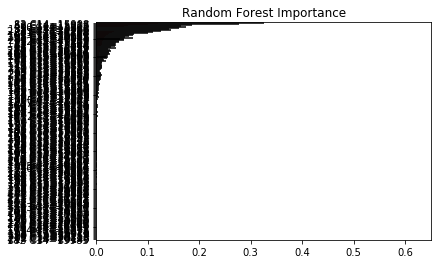

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

feature_names = dict_one_hot_encoder.get_feature_names()
print(len(feature_names))

feature_names = np.array([' '.join([str(b), a]) for a, b in zip(feature_names, range(len(feature_names)))])

importance = np.mean([tree.feature_importances_ for tree in random_forest_best.estimators_], axis = 0)
std = np.std([tree.feature_importances_ for tree in random_forest_best.estimators_], axis = 0)

indices = np.argsort(importance)
range_ = range(len(importance))

plt.figure()
plt.title("Random Forest Importance")
plt.barh(range_, importance[indices], color = "r", xerr = std[indices], alpha = 0.4, align = "center")
plt.yticks(range(len(importance)), feature_names[indices])
plt.ylim([-1, len(importance)])
plt.xlim([0.0, 0.65])

plt.show()